In [221]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import initializers
from tensorflow.keras.models import load_model
import tensorflow as tf

In [222]:
# "Time Series Forecasting" -- File: "BeerWineLiquor.csv" -- 
# Source:https://www.kaggle.com/bulentsiyah/for-simple-exercises-time-series-forecasting?select=BeerWineLiquor.csv
dataset = pd.read_csv('sample_data/BeerWineLiquor.csv')

In [223]:
# rename columns
dataset.rename(columns={'beer': 'Beer_Sales'}, inplace=True)
dataset.rename(columns={'date': 'DATE'}, inplace='True')
dataset.head(10)

,DATE,Beer_Sales
0,1/1/1992,1509
1,2/1/1992,1541
2,3/1/1992,1597
3,4/1/1992,1675
4,5/1/1992,1822
5,6/1/1992,1775
6,7/1/1992,1912
7,8/1/1992,1862
8,9/1/1992,1770
9,10/1/1992,1882


In [224]:
# 'DATE' column is concerted from 'object' type to 'datetime' type
dataset['DATE'] = pd.to_datetime(dataset['DATE'])
dataset['Year'] = dataset['DATE'].apply(lambda date: date.year)
dataset['Month'] = dataset['DATE'].apply(lambda date: date.month)
dataset.head(10)

,DATE,Beer_Sales,Year,Month
0,1992-01-01,1509,1992,1
1,1992-02-01,1541,1992,2
2,1992-03-01,1597,1992,3
3,1992-04-01,1675,1992,4
4,1992-05-01,1822,1992,5
5,1992-06-01,1775,1992,6
6,1992-07-01,1912,1992,7
7,1992-08-01,1862,1992,8
8,1992-09-01,1770,1992,9
9,1992-10-01,1882,1992,10


In [225]:
# DATE column is set as an index
dataset = dataset.set_index(['DATE'])
dataset.head(5)

,Beer_Sales,Year,Month
DATE,,,
1992-01-01,1509,1992,1
1992-02-01,1541,1992,2
1992-03-01,1597,1992,3
1992-04-01,1675,1992,4
1992-05-01,1822,1992,5


In [226]:
# get some info
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 324 entries, 1992-01-01 to 2018-12-01
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Beer_Sales  324 non-null    int64
 1   Year        324 non-null    int64
 2   Month       324 non-null    int64
dtypes: int64(3)
memory usage: 10.1 KB


In [227]:
num_to_name = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct',
               11: 'Nov', 12: 'Dec'}
# dataset['Month'] = dataset['Month'].map(num_to_name)
dataset['Month'] = dataset['Month'].apply(lambda num: num_to_name[num])
dataset.head(10)

,Beer_Sales,Year,Month
DATE,,,
1992-01-01,1509,1992,Jan
1992-02-01,1541,1992,Feb
1992-03-01,1597,1992,Mar
1992-04-01,1675,1992,Apr
1992-05-01,1822,1992,May
1992-06-01,1775,1992,Jun
1992-07-01,1912,1992,Jul
1992-08-01,1862,1992,Aug
1992-09-01,1770,1992,Sep


C:\Users\bender\miniconda3\envs\tf_gpu\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Density')

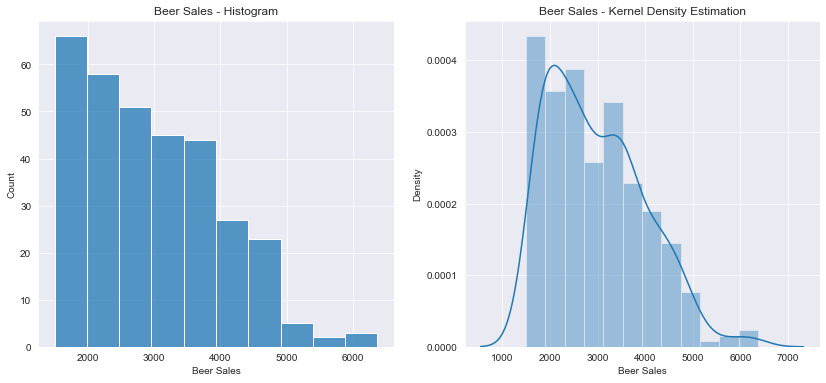

In [228]:
# Sales histogram and kernel density plots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
sns.histplot(dataset['Beer_Sales'], kde=False, bins=10, ax=axs[0])
axs[0].set_title('Beer Sales - Histogram')
axs[0].set_xlabel('Beer Sales')
axs[0].set_ylabel('Count')

sns.distplot(dataset['Beer_Sales'], kde=True, hist=10, ax=axs[1])
axs[1].set_title('Beer Sales - Kernel Density Estimation')
axs[1].set_xlabel('Beer Sales')
axs[1].set_ylabel('Density')

Text(0.5, 1.0, 'Sales grouped by Year')

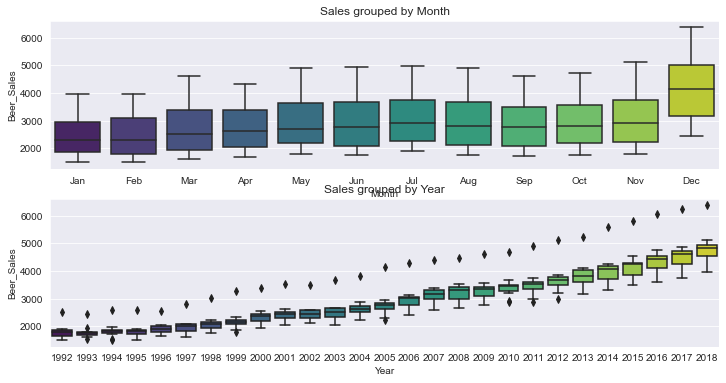

In [229]:
# Box plots of Beer sales grouped by Month and Year
figs, axs = plt.subplots(2, 1, figsize=(12, 6))

sns.boxplot(x='Month', data=dataset, y='Beer_Sales', palette='viridis', ax=axs[0])
axs[1].set_xlabel('Month')
axs[0].set_ylabel('Beer_Sales')
axs[0].set_title("Sales grouped by Month")

sns.boxplot(x='Year', data=dataset, y='Beer_Sales', palette='viridis', ax=axs[1])
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Beer_Sales')
axs[1].set_title("Sales grouped by Year")

In [230]:
# drop Year and Month columns from the dataset
data = dataset.drop(['Year', 'Month'], axis=1)
data.head()

,Beer_Sales
DATE,
1992-01-01,1509
1992-02-01,1541
1992-03-01,1597
1992-04-01,1675
1992-05-01,1822


Text(0.5, 1.0, 'Beer Sales Times Series')

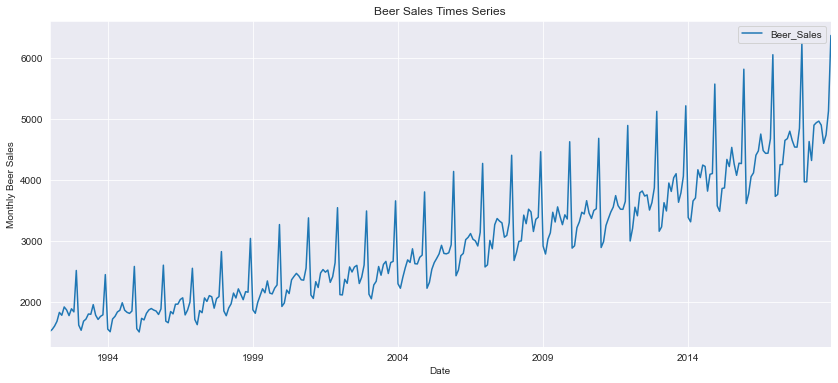

In [231]:
# Time series plot
data.plot(figsize=(14, 6))
plt.xlabel('Date')
plt.ylabel('Monthly Beer Sales')
plt.title("Beer Sales Times Series")

In [232]:
# Test size 12 months
test_size = 12

# Split dataset to training and testing
training_data = data.iloc[:len(dataset) - test_size]
testing_data = data.iloc[-test_size:]
print(f"The size of the training data set is {len(training_data)}")
print(f"The size of the testing data set is {len(testing_data)}")

The size of the training data set is 312
The size of the testing data set is 12


In [233]:
# Scale data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(training_data)
scaled_training_data = scaler.transform(training_data)
scaled_testing_data = scaler.transform(testing_data)

In [234]:
# Training Batch length
length = 11
# No. of features
n_features = 1
# Creating the time series generator
time_series_generator = TimeseriesGenerator(scaled_training_data, scaled_training_data, length=length, batch_size=1)

In [235]:
TRAIN = False

if TRAIN:
    # set seed to replicate results
    tf.random.set_seed(0)
    np.random.seed(0)

    # use of the he_uniform initializer to set the initial random weights of the model
    initializer = tf.keras.initializers.he_uniform(seed=0)

    model = Sequential()

    # Hidden layer neurons are chosen to be 11  which is equal to the defined length (number input samples per batch)
    # Selected Activation function has been the rectified linear unit
    model.add(LSTM(units=11, activation='relu', input_shape=(length, n_features), kernel_initializer=initializer))
    # The output layer consists of 1 neuron with a 'linear' activation fuction
    model.add(Dense(units=1, activation='linear', kernel_initializer=initializer))
    # The model is compiled using MSE as  loss function and Adam as optimizer
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='mse')

    # A validation generator is constructed in a similar way to the previous time_series_generator with the only difference being
    # the use of scaled_test values for validation purposes
    time_series_val_generator = TimeseriesGenerator(scaled_testing_data, scaled_testing_data, length=length,
                                                    batch_size=1)

    # The model is trained for 1000 epochs. At each epoch both training and validation losses can be observed
    model.fit(time_series_generator, epochs=100, shuffle=False, validation_data=time_series_val_generator)
    model.save('LSTM_beer')
else:
    model = load_model('.\LSTM_beer')

In [238]:
# Determining all LSTM outputs
training_outputs = []
batch = scaled_training_data[:length].reshape((1, length, n_features))

for i in range(len(scaled_training_data[length:])):
    train_out = model.predict(batch)[0]
    training_outputs.append(train_out)
    batch = np.append(batch[:, 1:, :], [[scaled_training_data[length:][i]]], axis=1)
    pass

actual_train = scaled_training_data[length:]
actual_train = scaler.inverse_transform(actual_train)

train_predictions = scaler.inverse_transform(training_outputs)

fig, axs = plt.subplots(2, 1, figsize=(12, 10))
axs[0].plot(actual_train, marker='o', linestyle='-', label='Target train values')
axs[0].plot(train_predictions, marker='o', linestyle='dashed', label='Predicted train values')
axs[0].set_title('LSTM Performance on the Training Set - Actual vs. Predicted Train Values',fontweight='bold')
axs[0].legend()
axs[0].set_xlabel('Time Steps')
axs[0].set_ylabel('Monthly Beer Sales')

KeyboardInterrupt: 